# Тема17b. NARX сеть

# NARX сеть

Идея NARX сети (Nonlinear AutoRegression with eXternal input, нелинейная авторегрессия с внешним входом).

Давайте позволим создавать только такие обратные связи, которые идут с выхода сети, а никаких других обратных связей нет (например, нет обратных связей со скрытого слоя и т.п.). 

Сеть все-равно будет рекуррентной и, казалось бы, ничего нового мы не достигли.

Но давайте задумаемся, чему мы учим нейронную сеть? 

Наша цель, сделать так, чтобы выходы сети совпадали как можно точнее с указаниями учителя, правда?

Предположим, что мы достигли этой цели, и указания учителя действительно полностью совпадают с выходами нейронной сети. 

В обратной связи используются выходы сети (точнее их предыдущие, запомненные значения), так давайте заменим их, раз они совпадают, на указания учителя!

Указания учителя **не зависят** от весов, ведь это данные которые мы собираем сами. И наша рекуррентная сеть превращается в обычную многослойную сеть, на вход которой подаются задержанные значения указаний учителя. А такие, не рекуррентные, сети мы умеем обучать эффективно.

Конечно, предположение, что выходы совпадают с указаниями учителя это лишь предположение. Но это наша цель, значит мы можем на время обучения забыть об этом различии, и если сеть обучится хорошо, то предположение станет правдивым.

В целом NARX сеть работает так:

- для обучения заменяем выходы сети на указания учителя,
- получается сеть без обратной связи, разомкнутая (такой режим работы так и называется, разомкнутый цикл, open-loop), обучаем ее как обычную многослойную сеть,
- после обучения, если оно хорошее, заменим обратно указания учителя на выход сети, получим сеть с обратной связью, уже обученную. Такой режим работы называется замкнутый цикл, closed-loop.

Теперь можем использовать обученную рекуррентную сеть. А если надо, то дообучить ее еще немного как рекуррентную.

Конечно, можно было бы обучать сеть изначально с обратной связью в замкнутом цикле, но, как вы понимаете, обучение рекуррентной сети гораздо-гораздо сложнее, ведь мы обязаны разворачивать ее во времени. 

А разомкнутая сеть в этом не нуждается, мы проводим обратное распространение только по слоям, но не по времени в развертке.

Практика показала высокую эффективность обучения по разомкнутому циклу. Понятно и ограничение, что мы можем использовать только обратные связи с выхода сети, ведь только их мы можем заменить на указания учителя.











![img](https://drive.google.com/uc?id=11UsMLharx8DlOeVYCs1ZaNGpdwvs6OFk)

**Рисунок.** Слева - замкнутый цикл, справа - разомкнутый. Квадратиками $q^{-1}$ обозначены задержки на один такт по времени. k - текущее время, x(k) - текущий вход, y(k) - текущее указание учителя для выхода, $\hat{y}(k) $ - текущий выход сети.

Кстати, внутри может использоваться любая сеть прямого распространения, но обычно это многослойный персептрон.




# NARX сеть в Sysidentpy 

Хорошая библиотека, которая позволяет делать NARX сеть (но не только ее) это [sysidentpy](https://github.com/wilsonrljr/sysidentpy). Она использует PyTorch для нейронных сетей, а в целом синтаксис похож и на sklearn. Собственно говоря, эта библиотека и занимается обучением сети по разомкнутому циклу, а потом замыкает его.

Установим библиотеку. При первой установке могут возникнуть не критичные ошибки и потребуется перезагрузка ядра "тетрадки", это не страшно, нажмите кнопку Restart Runtime, а затем продолжите работу.

In [1]:
# установка
pip install sysidentpy

     |████████████████████████████████| 21.5MB 1.3MB/s 
     |████████████████████████████████| 10.3MB 49.7MB/s 
     |████████████████████████████████| 776.8MB 21kB/s 
  Created wheel for sysidentpy: filename=sysidentpy-0.1.5.3-cp37-none-any.whl size=44898 sha256=c0cfddaa7d4c94b83df421531edc8415e56798051afd8de1f1f593a88b1be547
  Stored in directory: /root/.cache/pip/wheels/98/9d/c4/2c0b10f56477c719bd6302153ffd1538a96f4492d415b02d23
Successfully built sysidentpy
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Found existing installation: torch 1.8.1+cu101
    Uninstalling t

In [1]:
# подключим библиотеки
from torch import nn # для нейронных сетей
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.metrics import mean_squared_error # функция ошибки
from sysidentpy.utils.generate_data import get_siso_data # функция для генерации данных примера
from sysidentpy.neural_network import NARXNN # сеть NARX

## Пример данных

Для примера попробуем построить модель, которая описывается следующей формулой:

$y_k = 0.2y_{k-1} + 0.1y_{k-1}x_{k-1} + 0.9x_{k-1} + e_{k}$.

Если флаг *colored_noise* выставлен в True, то:

$e_{k} = 0.8\nu_{k-1} + \nu_{k}$,

здесь $x$ is равномерно распределенная случайная величина,  $\nu$ случайная величина с распределением Гаусса со средним $\mu=0$ и разбросом $\sigma=0.1$

Создадим данные, это примеры входов x и выходов y, разделив их на обучающие (первые 80% отсчетов времени и тестовые последние 20% отсчетов времени).

Это нелинейная формула, довольно сложная, устанавливает не только взаимосвязь между временными отсчетами, но и добавляет шум. Такого рода формулами описываются и реальные объекты.

Здесь мы предполагаем, что формулу взаимосвязи мы не знаем, а можем только получить измеренные значения входов и выходов. Наша цель - спрогнозировать выход при других входах, что и означает построить хорошую модель.

In [2]:
#  создаем данные
x_train, x_valid, y_train, y_valid = get_siso_data(n=1000, # число временных отсчетов
                                                   colored_noise=False, # шум
                                                   sigma=0.01, # разброс шума
                                                   train_percentage=80) # процент данных для обучения

## Параметры NARX, функции ошибки, оптимизатора

В NARX сети мы должны задавать число задержек для входа и выхода, на сколько отсчетов мы запоминаем их значения. Выбор конкретного числа зависит от задачи, для нашего примера мы понимаем, что зависимость есть как минимум на два такта - текущий и предыдущий.  

Для функции ошибки можно выбрать любую из torch.nn.functional. [Click here](https://pytorch.org/docs/stable/nn.functional.html#loss-functions). Для регрессии логично выбрать MSE.

Опции оптимизатора также задаются из torch.optim. [Click here](https://pytorch.org/docs/stable/optim.html).



In [3]:
# создаем NARX сеть
narx_net = NARXNN(ylag=2, #  максимальная задержка выхода
                  xlag=2, #  максимальная задержка входа
                  loss_func='mse_loss', # функция ошибки
                  optimizer='Adam', # метод обучения
                  epochs=200, # количество эпох
                  verbose=True, # показывать ли информацию обучения
                  optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # параметры оптимизатора
)

При выбранных величинах задержек $ylag=2$ and $xlag=2$, получаем матрицу регрессии из 4 элементов. Библиотека сама создаст необходимые данные (входы и указания учителя) с задержками, нам не надо об этом задумываться. 

Можно узнать сколько элемнтов в матрице регрессии:

In [4]:
len(narx_net.regressor_code) # число элементов в матрице регрессии

4

## Создание внутренней сети для NARX

Надо указать, какая именно (разомкнутая) сеть будет использоваться в NARX сети. Создадим ее, например, как класс, определив метод `__init__` и `forward()` используя слои PyTorch. 

In [5]:
# разомкнутая сеть 
class NARX(nn.Module): # базовый класс
    def __init__(self): # инициализация
        super().__init__()
        # слои
        self.lin = nn.Linear(4, 10) # линейный с 10 нейронами и 4 входами
        self.lin2 = nn.Linear(10, 10) # линейный с 10 нейронами и 10 входами
        self.lin3 = nn.Linear(10, 1) # линейный с 1 нейроном и 10 входами
        self.tanh = nn.Tanh() # функций активации, пусть будет одинаковая для всех скрытых слоев 
    # расчет выходов
    def forward(self, xb): # принимает вход
        z = self.lin(xb) # выход первого слоя
        z = self.tanh(z) # активация его
        z = self.lin2(z) # второй слой
        z = self.tanh(z) # активация
        z = self.lin3(z) # третий слой, ему активацию не делаем
        return z

Имея такой класс, укажем его в поле `.net` NARX сети.

In [6]:
# указываем используемую разомкнутую сеть
narx_net.net = NARX() 

## Преобразование Numpy array в Tensor

В Pytorch используется специальный тип данных tensor, надо преобразовать все массивы в него, используем метод `data_transform`. Он будет содержать примеры входов и указания учителя.

In [7]:
train_dl = narx_net.data_transform(x_train, y_train) #  преобразуем в tensor обучающие данные
valid_dl = narx_net.data_transform(x_valid, y_valid) #  преобразуем в tensor тестовые данные

## Обучение Fit и предсказание Predict

Обучение и предсказание выполняются уже известными нам методами `fit` и `predict`:

In [8]:
narx_net.fit(train_dl, valid_dl) # обучение, первый аргумент обучающий тензор, второй - проверочный

05-08 16:43:43 - INFO - Train metrics: 0.18447846984654143 | Validation metrics: 0.1741375271419082
05-08 16:43:43 - INFO - Train metrics: 0.04124017282013308 | Validation metrics: 0.03802824400440611
05-08 16:43:43 - INFO - Train metrics: 0.016888324810859553 | Validation metrics: 0.01637443725132581
05-08 16:43:43 - INFO - Train metrics: 0.005539622764688984 | Validation metrics: 0.004972645495500829
05-08 16:43:43 - INFO - Train metrics: 0.006182150726199598 | Validation metrics: 0.006033236250243705
05-08 16:43:43 - INFO - Train metrics: 0.002382292985836777 | Validation metrics: 0.00231071709269526
05-08 16:43:43 - INFO - Train metrics: 0.0024308848141092704 | Validation metrics: 0.002430092329347525
05-08 16:43:43 - INFO - Train metrics: 0.0018729984784792912 | Validation metrics: 0.0018434851134026592
05-08 16:43:43 - INFO - Train metrics: 0.0015840409408185753 | Validation metrics: 0.001569925449939087
05-08 16:43:43 - INFO - Train metrics: 0.0016026392979967526 | Validation me

Для предсказания указываем примеры входов (первый аргумент) и *начальные значения* выходов, с которых и будет идти прогноз. Этих начальных значений должно быть столько, сколько задержек используется для выходов. Вообще, от них тоже будет зависеть качество прогноза. Но в нашем простом примере начальные значения не сильно влияют на качество, проверьте.
  

In [32]:
yhat = narx_net.predict(x_valid, y_valid[0:1]) # предсказание, первый аргумент - входы, второй - начальные значения выходов.

Можно нарисовать предсказания. Дополнительные графики показывают автокорреляцию отклонений и взаимную корреляцию между входами и отклонениями. Отклонение - разность между предсказанным и дествительным значением.  



0.001202676153363102


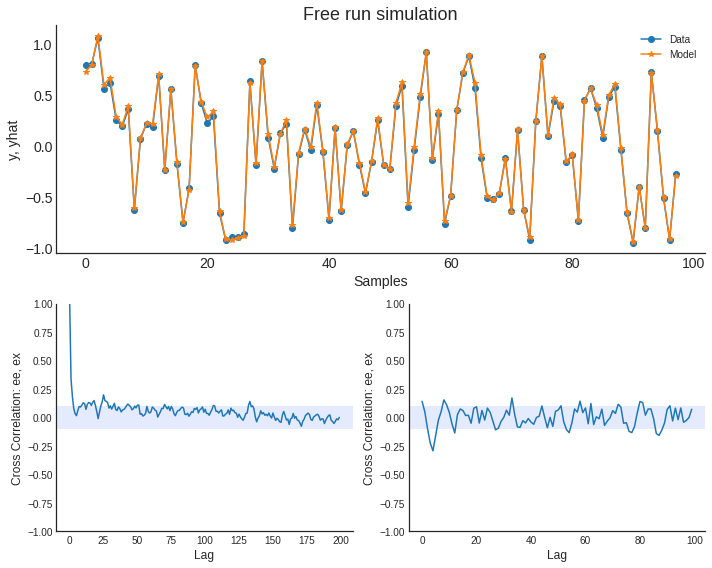

In [34]:
print(mean_squared_error(y_valid, yhat)) # ошибка на тестовых данных

ee, ex, extras, lam = narx_net.residuals(x_valid, y_valid, yhat) # корреляция
narx_net.plot_result(y_valid, yhat, ee, ex) #  рисуем

Что ж, у нас получилось замечательно предсказать выходные значения.

Для упражнения попробуйте

а) поменять разомкнутую сеть
б) изменить параметры обучения
в) число задержек
г) начальные значения выходов для предсказания.

## Заметка

Если разомкнутая сеть была создана заранее, до создание ее NARX варианта, то ее можно передать в аргументе `net`.

05-08 17:16:38 - INFO - Train metrics: 0.0904349897962465 | Validation metrics: 0.08448567700506461
05-08 17:16:38 - INFO - Train metrics: 0.01704944529685012 | Validation metrics: 0.01594094138103302
05-08 17:16:38 - INFO - Train metrics: 0.007960040967229912 | Validation metrics: 0.008467362074162623
05-08 17:16:38 - INFO - Train metrics: 0.00789636071832071 | Validation metrics: 0.006147328707756418
05-08 17:16:38 - INFO - Train metrics: 0.0024872647550535903 | Validation metrics: 0.0019735712158220884
05-08 17:16:38 - INFO - Train metrics: 0.003355891233716244 | Validation metrics: 0.0031282691040424387
05-08 17:16:38 - INFO - Train metrics: 0.0023510818662037863 | Validation metrics: 0.0018839437039474948
05-08 17:16:38 - INFO - Train metrics: 0.0021687436362793832 | Validation metrics: 0.0018435549861140022
05-08 17:16:38 - INFO - Train metrics: 0.002068874432021439 | Validation metrics: 0.00190337399853337
05-08 17:16:38 - INFO - Train metrics: 0.0019290044519788864 | Validation

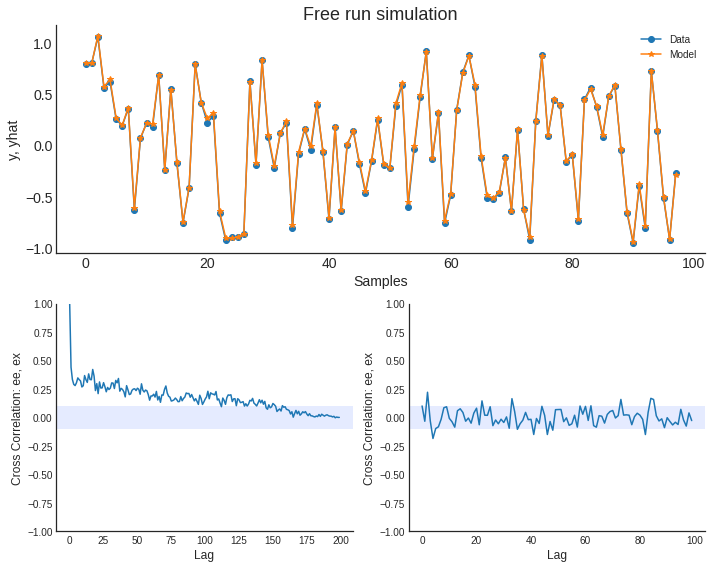

In [37]:
# делаем сеть заранее
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z
# NARX
narx_net2 = NARXNN(net=NARX(), # передаем ее в аргументе
                   ylag=2,
                   xlag=2,
                   loss_func='mse_loss',
                   optimizer='Adam',
                   epochs=200,
                   verbose=True,
                   optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

narx_net2.fit(train_dl, valid_dl)
yhat = narx_net2.predict(x_valid, y_valid)

ee, ex, extras, lam = narx_net2.residuals(x_valid, y_valid, yhat)
narx_net2.plot_result(y_valid, yhat, ee, ex)

# Ссылки

Использованы и адаптированы материалы:

https://github.com/wilsonrljr/sysidentpy/blob/master/examples/narx_neural_network.ipynb 

[Parallel Training Considered Harmful?: Comparing series-parallel and parallel feedforward
network training](https://arxiv.org/pdf/1706.07119.pdf)